In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
%cd batches_different_length/

/home/ec2-user/SageMaker/code-paco/Named-Entity-Recognition-with-Bidirectional-LSTM-CNNs/batches_different_length


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from keras.initializers import RandomUniform
from keras.layers import (
    LSTM,
    Bidirectional,
    Conv1D,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    Input,
    MaxPooling1D,
    TimeDistributed,
    concatenate,
)
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import Progbar

from prepro import add_char_information, create_batches, create_matrices, iterate_minibatches, padding, readfile, tag_dataset
from validation import compute_f1

# Prepare Data

### Download data

In [14]:
# %cd embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip
# %cd ..

### Load data

In [16]:
train_sentences = readfile("../data/train.txt")
val_sentences = readfile("../data/valid.txt")
test_sentences = readfile("../data/test.txt")
print(len(train_sentences), len(val_sentences), len(test_sentences))

14041 3250 3453


In [17]:
train_sentences[0]

[['EU', 'B-ORG\n'],
 ['rejects', 'O\n'],
 ['German', 'B-MISC\n'],
 ['call', 'O\n'],
 ['to', 'O\n'],
 ['boycott', 'O\n'],
 ['British', 'B-MISC\n'],
 ['lamb', 'O\n'],
 ['.', 'O\n']]

### Add character information

In [18]:
train_sentences = add_char_information(train_sentences)
val_sentences = add_char_information(val_sentences)
test_sentences = add_char_information(test_sentences)
all_sentences = train_sentences + val_sentences + test_sentences

In [19]:
train_sentences[0]

[['EU', ['E', 'U'], 'B-ORG\n'],
 ['rejects', ['r', 'e', 'j', 'e', 'c', 't', 's'], 'O\n'],
 ['German', ['G', 'e', 'r', 'm', 'a', 'n'], 'B-MISC\n'],
 ['call', ['c', 'a', 'l', 'l'], 'O\n'],
 ['to', ['t', 'o'], 'O\n'],
 ['boycott', ['b', 'o', 'y', 'c', 'o', 't', 't'], 'O\n'],
 ['British', ['B', 'r', 'i', 't', 'i', 's', 'h'], 'B-MISC\n'],
 ['lamb', ['l', 'a', 'm', 'b'], 'O\n'],
 ['.', ['.'], 'O\n']]

### Visualize

#### Sentence length

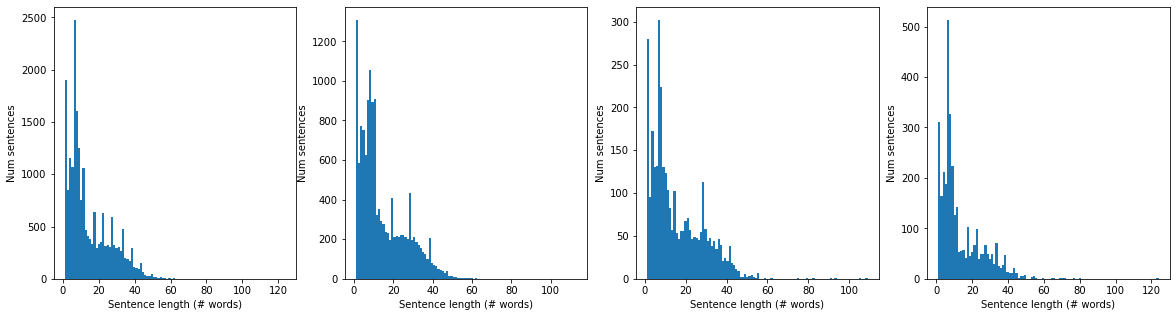

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for ax, sentences_set in zip(axs, [all_sentences, train_sentences, val_sentences, test_sentences]):
    sentences_lens = [len(sentence) for sentence in sentences_set]
    ax.hist(sentences_lens, bins=100)
    ax.set_ylabel("Num sentences")
    ax.set_xlabel("Sentence length (# words)");

#### Word length

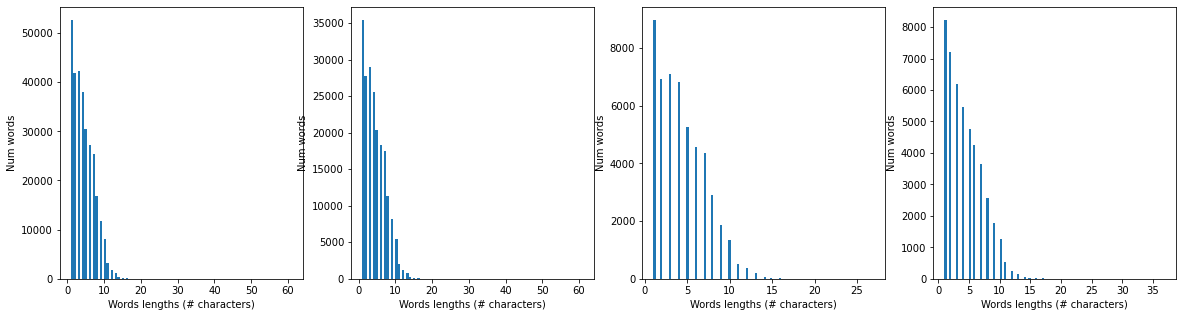

In [21]:
fig, axs = plt.subplots(1,4, figsize=(20, 5))
for ax, sentences_set in zip(axs, [all_sentences, train_sentences, val_sentences, test_sentences]):
    word_lens = [len(word[0]) for sentence in sentences_set for word in sentence]
    ax.hist(word_lens, bins=100)
    ax.set_ylabel("Num words")
    ax.set_xlabel("Words lengths (# characters)");

### Prepare mappings and embeddings

#### Get classes and word corpus

In [25]:
classes = set()
words = {}

for dataset in [train_sentences, val_sentences, test_sentences]:
    for sentence in dataset:
        for word, char, label in sentence:
            classes.add(label)
            words[word.lower()] = True

In [26]:
print(len(classes), len(words))

9 26869


#### Classes mapping

In [27]:
# Create a mapping for the classes
class2idx = {}
for label in classes:
    class2idx[label] = len(class2idx)
print(len(class2idx))
print(class2idx)

9
{'I-ORG\n': 0, 'B-ORG\n': 1, 'O\n': 2, 'B-MISC\n': 3, 'B-LOC\n': 4, 'I-MISC\n': 5, 'I-LOC\n': 6, 'I-PER\n': 7, 'B-PER\n': 8}


In [28]:
# Create reverse mapping for classes and store it
idx2class = {v: k for k, v in class2idx.items()}
np.save("models/idx2Label.npy", idx2class)
print(idx2class)

{0: 'I-ORG\n', 1: 'B-ORG\n', 2: 'O\n', 3: 'B-MISC\n', 4: 'B-LOC\n', 5: 'I-MISC\n', 6: 'I-LOC\n', 7: 'I-PER\n', 8: 'B-PER\n'}


#### Cases mapping and embedding

In [29]:
# Create a look-up table for the cases
case2idx = {
    "numeric": 0,
    "allLower": 1,
    "allUpper": 2,
    "initialUpper": 3,
    "other": 4,
    "mainly_numeric": 5,
    "contains_digit": 6,
    "PADDING_TOKEN": 7,
}
case_embeddings = np.identity(len(case2idx), dtype="float32")
print(len(case2idx), case_embeddings.shape)
print(case2idx)
print(case_embeddings)

8 (8, 8)
{'numeric': 0, 'allLower': 1, 'allUpper': 2, 'initialUpper': 3, 'other': 4, 'mainly_numeric': 5, 'contains_digit': 6, 'PADDING_TOKEN': 7}
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


#### Word mapping and embeddings

In [31]:
# Get word embedding
word2idx = {}
word_embeddings = []

vocabulary_embeddings = open("../embeddings/glove.6B.50d.txt", encoding="utf-8")

for line in vocabulary_embeddings:
    split = line.strip().split(" ")
    word = split[0]

    if len(word2idx) == 0:  # Add padding+unknown
        word2idx["PADDING_TOKEN"] = len(word2idx)
        vector = np.zeros(len(split) - 1)  # Zero vector vor 'PADDING' word
        word_embeddings.append(vector)

        word2idx["UNKNOWN_TOKEN"] = len(word2idx)
        vector = np.random.uniform(-0.25, 0.25, len(split) - 1)
        word_embeddings.append(vector)

    if split[0].lower() in words:
        vector = np.array([float(num) for num in split[1:]])
        word_embeddings.append(vector)
        word2idx[split[0]] = len(word2idx)

word_embeddings = np.array(word_embeddings)

print(len(word2idx), word_embeddings.shape)

22949 (22949, 50)


In [32]:
# Store word embedding indices
np.save("models/word2idx.npy", word2idx)

#### Character mapping and embedding

In [33]:
# Character embedding
char2idx = {"PADDING": 0, "UNKNOWN": 1}
for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|":
    char2idx[c] = len(char2idx)
print(len(char2idx))

95


### Train, val test data splits

In [34]:
train_set = padding(create_matrices(train_sentences, word2idx, class2idx, case2idx, char2idx))
val_set = padding(create_matrices(val_sentences, word2idx, class2idx, case2idx, char2idx))
test_set = padding(create_matrices(test_sentences, word2idx, class2idx, case2idx, char2idx))
print(f"num train sentences: {len(train_set)}")
print(f"num val sentences: {len(val_set)}")
print(f"num test sentences: {len(test_set)}")

num train sentences: 14041
num val sentences: 3250
num test sentences: 3453


In [35]:
train_set[0] # [words_idxs, word_case_idxs, word_char_idx, word_class_idx]

[[641, 6732, 512, 578, 6, 4940, 295, 8353, 4],
 [2, 1, 3, 1, 1, 1, 3, 1, 4],
 array([[43, 59,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [30, 17, 22, 17, 15, 32, 31,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [45, 17, 30, 25, 13, 26,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [15, 13, 24, 24,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  

In [36]:
sentence_idx = 10
print(f"Raw data of train sentence {sentence_idx}:")
print(f"{train_sentences[sentence_idx]}")
print(f"Sentence has {len(train_sentences[sentence_idx])} words")
print("word embedding idxs:", len(train_set[sentence_idx][0]), train_set[sentence_idx][0])
print("word case embedding idxs:", len(train_set[sentence_idx][1]), train_set[sentence_idx][1])
print("word char embedding idxs:", train_set[sentence_idx][2].shape)
print("word class embedding idxs:", len(train_set[sentence_idx][3]), train_set[sentence_idx][3])

Raw data of train sentence 10:
[['Spanish', ['S', 'p', 'a', 'n', 'i', 's', 'h'], 'B-MISC\n'], ['Farm', ['F', 'a', 'r', 'm'], 'O\n'], ['Minister', ['M', 'i', 'n', 'i', 's', 't', 'e', 'r'], 'O\n'], ['Loyola', ['L', 'o', 'y', 'o', 'l', 'a'], 'B-PER\n'], ['de', ['d', 'e'], 'I-PER\n'], ['Palacio', ['P', 'a', 'l', 'a', 'c', 'i', 'o'], 'I-PER\n'], ['had', ['h', 'a', 'd'], 'O\n'], ['earlier', ['e', 'a', 'r', 'l', 'i', 'e', 'r'], 'O\n'], ['accused', ['a', 'c', 'c', 'u', 's', 'e', 'd'], 'O\n'], ['Fischler', ['F', 'i', 's', 'c', 'h', 'l', 'e', 'r'], 'B-PER\n'], ['at', ['a', 't'], 'O\n'], ['an', ['a', 'n'], 'O\n'], ['EU', ['E', 'U'], 'B-ORG\n'], ['farm', ['f', 'a', 'r', 'm'], 'O\n'], ['ministers', ['m', 'i', 'n', 'i', 's', 't', 'e', 'r', 's'], 'O\n'], ["'", ["'"], 'O\n'], ['meeting', ['m', 'e', 'e', 't', 'i', 'n', 'g'], 'O\n'], ['of', ['o', 'f'], 'O\n'], ['causing', ['c', 'a', 'u', 's', 'i', 'n', 'g'], 'O\n'], ['unjustified', ['u', 'n', 'j', 'u', 's', 't', 'i', 'f', 'i', 'e', 'd'], 'O\n'], ['alarm

### Create training batches per sentence length

In [37]:
# Order sentences by length of sentence and return the index at which each length starts
train_unique_lengths, train_batches, train_num_sentences_in_batch = create_batches(train_set)
val_unique_lengths, val_batches, val_num_sentences_in_batch = create_batches(val_set)
test_unique_lengths, test_batches, test_num_sentences_in_batch = create_batches(test_set)

In [38]:
print(train_unique_lengths)
print(len(train_batches))
print(train_num_sentences_in_batch)

print(val_unique_lengths)
print(len(val_batches))
print(val_num_sentences_in_batch)

print(test_unique_lengths)
print(len(test_batches))
print(test_num_sentences_in_batch)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 67, 78, 113}
14041
[179, 1308, 1894, 2665, 3416, 4041, 4945, 6001, 6895, 7398, 7805, 8129, 8483, 8776, 9055, 9290, 9523, 9721, 9916, 10130, 10343, 10560, 10770, 10991, 11214, 11426, 11628, 11845, 12061, 12255, 12464, 12650, 12823, 12978, 13113, 13237, 13339, 13437, 13546, 13626, 13698, 13762, 13814, 13859, 13899, 13926, 13947, 13965, 13978, 13993, 14003, 14014, 14017, 14021, 14026, 14027, 14030, 14032, 14034, 14036, 14038, 14039, 14040, 14041]
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 59, 62, 75, 79, 83, 91, 93, 105, 109}
3250
[15, 280, 376, 549, 679, 811, 1113, 1337, 1467, 1590, 169

### Define model

In [39]:
# Word features come from glove.6B embeddings
words_input = Input(shape=(None,), dtype="int32", name="words_input") # None indicates a variables input (sentence length is variable)
words = Embedding(
    input_dim=word_embeddings.shape[0], output_dim=word_embeddings.shape[1], weights=[word_embeddings], trainable=False
)(words_input)

# Casing features
casing_input = Input(shape=(None,), dtype="int32", name="casing_input") # None indicates a variables input (sentence length is variable)
casing = Embedding(
    output_dim=case_embeddings.shape[1], input_dim=case_embeddings.shape[0], weights=[case_embeddings], trainable=False
)(casing_input)

# Character features learned with a 1D CNN
character_input = Input(
    shape=(
        None,
        52,
    ),
    name="char_input",
)
embed_char_out = TimeDistributed(
    Embedding(len(char2idx), 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name="char_embedding"
)(character_input)
dropout = Dropout(0.5)(embed_char_out)
conv1d_out = TimeDistributed(Conv1D(kernel_size=3, filters=30, padding="same", activation="tanh", strides=1))(dropout)
maxpool_out = TimeDistributed(MaxPooling1D(52))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(0.5)(char)

# Concatenate features
output = concatenate([words, casing, char])

# Bidirectional LSTM
output = Bidirectional(LSTM(200, return_sequences=True, dropout=0.50, recurrent_dropout=0.25))(output)

# Same fully connected for each word in the sequence
output = TimeDistributed(Dense(len(class2idx), activation="softmax"))(output)

# Define model input and output
model = Model(inputs=[words_input, casing_input, character_input], outputs=[output])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, None, 52)     0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, None, 52, 30) 2850        char_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 52, 30) 0           char_embedding[0][0]             
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 52, 30) 2730        dropout_1[0][0]                  
____________________________________________________________________________________________

### Training loop

In [40]:
epochs = 2
for epoch in range(epochs):
    print("Epoch %d/%d" % (epoch, epochs))
    a = Progbar(len(train_num_sentences_in_batch))
    for i, batch in enumerate(iterate_minibatches(train_batches, train_num_sentences_in_batch)):
        labels, words, casing, char = batch
        print(labels.shape, words.shape, casing.shape, char.shape)
        model.train_on_batch([words, casing, char], labels)
        a.update(i)
    a.update(i + 1)
    print(" ")

Epoch 0/2
(179, 1, 1) (179, 1) (179, 1) (179, 1, 52)


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


64/64 [==============================] - 35s 548ms/step
 
Epoch 1/2
(179, 1, 1) (179, 1) (179, 1) (179, 1, 52)
64/64 [==============================] - 28s 437ms/step
 


In [ ]:
char

In [ ]:
model.save("models/model.h5")

### Performance in validation set

In [ ]:
def tag_dataset(model, dataset):
    correctLabels = []
    predLabels = []
    b = Progbar(len(dataset))
    for i, data in enumerate(dataset):
        tokens, casing, char, labels = data
        tokens = np.asarray([tokens])
        casing = np.asarray([casing])
        char = np.asarray([char])
        pred = model.predict([tokens, casing, char], verbose=False)[0]
        pred = pred.argmax(axis=-1)  # Predict the classes
        correctLabels.append(labels)
        predLabels.append(pred)
        b.update(i)
    b.update(i + 1)
    return predLabels, correctLabels

In [ ]:
predicted_classes, correct_classes = tag_dataset(model, val_batches)

In [ ]:
precision, recall, f1 = compute_f1(predicted_classes, correct_classes, idx2class)
print("Dev-Data: Prec: %.3f, Rec: %.3f, F1: %.3f" % (precision, recall, f1))

### Performance in test set

In [ ]:
predicted_classes, correct_classes = tag_dataset(model, test_batches)

In [ ]:
precision, recall, f1 = compute_f1(predicted_classes, correct_classes, idx2class)
print("Dev-Data: Prec: %.3f, Rec: %.3f, F1: %.3f" % (precision, recall, f1
))

In [ ]:
layer_output=model.get_layer(layer_name).output
intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(x_train[2].reshape(1,28,28,1))